In [1]:
import pickle
import pandas as pd
from collections import defaultdict, OrderedDict, Counter
import time
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import re
import os
import scipy
import urllib

import sys
sys.path.append("/home/yara/Documents/PseudoFind")
from PseudoFind.pangenome_cmds import *

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_validate, cross_val_predict,  GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [3]:
from machine_learning_pipeline import *
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [23]:
col_rows = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/allele_matrix/col_rows.p', 'rb'))
gid_order = col_rows[0]
FT_LRI = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f2.csv', dtype = {'Genome ID':str}).set_index('Genome ID').loc[gid_order].reset_index()

directory = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/allele_matrix/'
input_matrix = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense().T

#a hold-out dataset

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
import random

labels = np.array(FT_LRI['cystic_fibrosis_status'])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(allele_matrix, labels)

for train_index, test_index in sss.split(allele_matrix, labels):
    data_FS, data_holdout = allele_matrix[train_index,:], allele_matrix[test_index,:]
    labels_FS, labels_holdout = labels[train_index], labels[test_index]
    
rand = np.array([random.randint(0, 1) for _ in range(data_FS.shape[0])])
data_FS = np.vstack((data_FS.T, rand)).T


np.savez('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/input_data.npz',
        train_index = train_index, 
        test_index = test_index,
         rand = rand
        )

print('The proportions are as follows. The percent of CF ')
print('in the full data-set is : %f%%'%(Counter(labels)[1]/float(len(labels))))
print('in the tranining data-set is : %f%%'%(Counter(labels_FS)[1]/float(len(labels_FS))))
print('in the validation data-set is : %f%%'%(Counter(labels_holdout)[1]/float(len(labels_holdout))))

The proportions are as follows. The percent of CF 
in the full data-set is : 0.643258%
in the tranining data-set is : 0.643234%
in the validation data-set is : 0.643357%


#b feature selection

In [5]:
models = {'LinearSVC':LinearSVC(penalty="l1", loss="squared_hinge", dual=False, max_iter = 10000, class_weight="balanced"), 
          'LogisticRegression':LogisticRegression(penalty= "l1", dual = False),
          'RandomForestClassifier':RandomForestClassifier(n_estimators = 100)
         }
all_rows = defaultdict(list)

for model_id, clf_i in models.items():
    for c in [0.5, 1, 2]:
        if model_id == 'RandomForestClassifier':
            clf = clf_i.fit(data_FS, labels_FS)
            coef_d = dict(zip(range(data_FS.shape[1]), clf.feature_importances_))
            d = {x:y for x,y in coef_d.items() if abs(y) > abs(coef_d[data_FS.shape[1] -1])}
        else:
            clf_i.C = c
            clf = clf_i.fit(data_FS, labels_FS)
            coef_d = dict(zip(range(data_FS.shape[1]), clf.coef_.tolist()[0]))
            d = {x:y for x,y in coef_d.items() if abs(y) > abs(coef_d[data_FS.shape[1] -1])}
        all_rows['%s - C=%d - random'%(model_id,c)] = d

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

In [6]:
pickle.dump(all_rows, open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/ML_trial_run_2.p', 'wb'))

#c train ML models

In [7]:
training_models = {
    'LogisticRegression':LogisticRegression(solver = 'lbfgs', max_iter = 10000),
    'ExtraTreesClassifier':ExtraTreesClassifier(n_estimators = 100),
    'RandomForest':RandomForestClassifier(n_estimators = 100),
    'LinearSVC':LinearSVC(penalty="l1", dual=False, max_iter = 10000),
    'LinearSVC(L-2)':LinearSVC(penalty="l2", max_iter = 10000)
}

rows = []
for training_model_id, clf in training_models.items():
    for selection_model_id, features in all_rows.items():
        selected_features = list(features.keys())
        skf = StratifiedKFold(n_splits=10)
        scores = cross_validate(clf, data_FS[:,selected_features], labels_FS, cv=skf, return_train_score = True)
        predicted = cross_val_predict(clf, data_FS[:,selected_features], labels_FS, cv=skf)
        overfitting_proxy = (np.median(scores['train_score']) - np.median(scores['test_score']))*100

        rows.append({'ML model':training_model_id, 'FS model':selection_model_id, 
                     'F-1':metrics.f1_score(labels_FS, predicted), 
                     'Accuracy':metrics.accuracy_score(labels_FS, predicted),
                    'ROC-AUC score': metrics.roc_auc_score(labels_FS, predicted), 
                    'jaccard':metrics.jaccard_similarity_score(labels_FS, predicted),
                    'MI':metrics.normalized_mutual_info_score(labels_FS, predicted),
                     'brier_score_loss':metrics.brier_score_loss(labels_FS, predicted),
                     'precision':metrics.precision_score(labels_FS, predicted),
                     'recall':metrics.recall_score(labels_FS, predicted),
                     'No. selected features':len(selected_features),
                     'Overfitting proxy':overfitting_proxy
                    })

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='a

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='a

In [8]:
scores_res = pd.DataFrame(rows)
scores_res = scores_res.sort_values(by = 'Overfitting proxy')
scores_res.to_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning//ML_trial_run_2_scores_res.csv')

#d choose best ML pipeline, run bootstrap and select minimum no. features

In [9]:
# input_data = np.load('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/input_data.npz')
# data_FS = input_data['data_FS']
# data_holdout = input_data['data_holdout']
# labels_FS = input_data['labels_FS']
# labels_holdout = input_data['labels_holdout']
# nonzero_indices = input_data['nonzero_indices']
# rand = input_data['rand']
# scores_res = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning//ML_trial_run_1_scores_res.csv')

In [10]:
clf_i = LinearSVC(penalty="l1", loss="squared_hinge", dual=False, max_iter = 100000, class_weight="balanced")

stratified_shuffle = StratifiedShuffleSplit(n_splits=200, test_size=0.1, random_state=0)
stratified_shuffle.get_n_splits(data_FS, labels_FS)

i = 0
bootstrap_rows = {}

for train_index, test_index in stratified_shuffle.split(data_FS, labels_FS):
    print(200-i)
    clf = clf_i.fit(data_FS[train_index,:], labels_FS[train_index])
    coef_d = dict(zip(range(data_FS.shape[1]), clf.coef_.tolist()[0]))
    d = {x:y for x,y in coef_d.items() if abs(y) > abs(coef_d[data_FS.shape[1] -1])}
    bootstrap_rows['Try_%d'%i] = d 
    i +=1 

200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [11]:
# pickle.dump(bootstrap_rows, open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/bootstrap_rows_SVC_trial_3.p', 'wb'))
pickle.dump(bootstrap_rows, open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/bootstrap_rows_SVC_trial_2.p', 'wb'))

Text(0.5, 1.0, 'Count of times a feature is selected in an SVM')

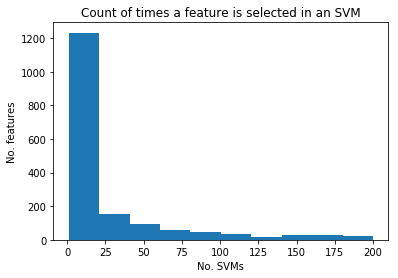

In [12]:
bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
bootstrap_res_i = bootstrap_res.copy()
bootstrap_res_i[bootstrap_res_i != 0] = 1
plt.hist(bootstrap_res_i.sum(axis = 1))
plt.xlabel('No. SVMs')
plt.ylabel('No. features')
plt.title('Count of times a feature is selected in an SVM')

In [33]:
from scipy.signal import *

In [43]:
pd.DataFrame(sorted_features)

,0
242087,109.576092
52237,109.137537
273742,91.086943
276630,76.028352
55447,74.361378
253486,65.908561
293487,64.724236
240337,59.524628
266708,54.714500
248932,53.857169


Text(0.5, 1.0, 'Sensitivity analysis of feature set for ML training')

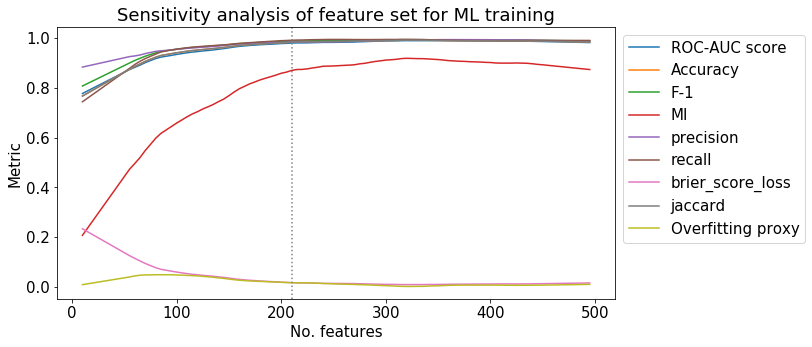

In [40]:
# bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
# sorted_features = abs(bootstrap_res).sum(axis = 1).sort_values(ascending = False)
# kappa = defaultdict(dict)

# skf = StratifiedKFold(n_splits=10)
# clf = LinearSVC(penalty="l2", max_iter = 10000, class_weight = 'balanced')
# scores_FS = []

# for i in range(10,500,5):
#     selected_features = sorted_features[:i].index
#     scores = cross_validate(clf, data_FS[:, selected_features], labels_FS, cv=skf, return_train_score = True)
#     predicted = cross_val_predict(clf, data_FS[:,selected_features], labels_FS, cv=skf)
#     overfitting_proxy = (np.median(scores['train_score']) - np.median(scores['test_score']))
    
    
#     scores_FS.append({
#                  'F-1':metrics.f1_score(labels_FS, predicted), 
#                  'Accuracy':metrics.accuracy_score(labels_FS, predicted),
# #                 'Accuracy (test)':metrics.accuracy_score(labels_holdout, predicted_test),
#                 'ROC-AUC score': metrics.roc_auc_score(labels_FS, predicted), 
#                 'jaccard':metrics.jaccard_similarity_score(labels_FS, predicted),
#                 'MI':metrics.normalized_mutual_info_score(labels_FS, predicted, average_method='arithmetic'),
#                  'brier_score_loss':metrics.brier_score_loss(labels_FS, predicted),
#                  'precision':metrics.precision_score(labels_FS, predicted),
#                  'recall':metrics.recall_score(labels_FS, predicted),
#                  'No. selected features':len(selected_features),
#                  'Overfitting proxy':overfitting_proxy
#                 })

scores_FS_df = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/bootstrap_scores_SCV_trial_2.csv')
# scores_FS_df = pd.DataFrame(scores_FS)

fig, axes = plt.subplots(1,1, figsize =  (10, 5))
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})

for score_type in ['ROC-AUC score', 'Accuracy','F-1', 'MI', 'precision', 'recall', 'brier_score_loss', 'jaccard', 'Overfitting proxy']:
    smoothed = scipy.signal.savgol_filter(scores_FS_df[score_type], 19, 1)
    plt.plot(scores_FS_df['No. selected features'], smoothed, '-', label = score_type)
plt.legend(bbox_to_anchor = (1,1))

t = min(scores_FS_df.loc[scores_FS_df['MI'] > 0.91]['No. selected features'])

plt.axvline(t, color = 'grey', linestyle = 'dotted')
plt.xlabel('No. features')
plt.ylabel('Metric')
plt.title('Sensitivity analysis of feature set for ML training')

Text(0.5, 1.0, 'Sensitivity analysis of feature set for ML training')

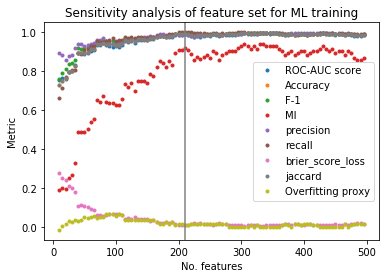

In [21]:
bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
sorted_features = abs(bootstrap_res).sum(axis = 1).sort_values(ascending = False)
kappa = defaultdict(dict)

skf = StratifiedKFold(n_splits=10)
clf = LinearSVC(penalty="l2", max_iter = 10000, class_weight = 'balanced')
scores_FS = []

for i in range(10,500,5):
    selected_features = sorted_features[:i].index
    scores = cross_validate(clf, data_FS[:, selected_features], labels_FS, cv=skf, return_train_score = True)
    predicted = cross_val_predict(clf, data_FS[:,selected_features], labels_FS, cv=skf)
    overfitting_proxy = (np.median(scores['train_score']) - np.median(scores['test_score']))
    
    
    scores_FS.append({
                 'F-1':metrics.f1_score(labels_FS, predicted), 
                 'Accuracy':metrics.accuracy_score(labels_FS, predicted),
#                 'Accuracy (test)':metrics.accuracy_score(labels_holdout, predicted_test),
                'ROC-AUC score': metrics.roc_auc_score(labels_FS, predicted), 
                'jaccard':metrics.jaccard_similarity_score(labels_FS, predicted),
                'MI':metrics.normalized_mutual_info_score(labels_FS, predicted, average_method='arithmetic'),
                 'brier_score_loss':metrics.brier_score_loss(labels_FS, predicted),
                 'precision':metrics.precision_score(labels_FS, predicted),
                 'recall':metrics.recall_score(labels_FS, predicted),
                 'No. selected features':len(selected_features),
                 'Overfitting proxy':overfitting_proxy
                })

scores_FS_df = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/bootstrap_scores_SCV_trial_2.csv')
# scores_FS_df = pd.DataFrame(scores_FS)
for score_type in ['ROC-AUC score', 'Accuracy','F-1', 'MI', 'precision', 'recall', 'brier_score_loss', 'jaccard', 'Overfitting proxy']:
    plt.plot(scores_FS_df['No. selected features'], scores_FS_df[score_type], '-', label = score_type)
plt.legend()

t = min(scores_FS_df.loc[scores_FS_df['MI'] > 0.91]['No. selected features'])

plt.axvline(t, color = 'grey')
plt.xlabel('No. features')
plt.ylabel('Metric')
plt.title('Sensitivity analysis of feature set for ML training')

In [14]:
# scores_FS_df.to_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/bootstrap_scores_SCV_trial_2.csv')
selected_features_final = sorted_features[:min(scores_FS_df.loc[scores_FS_df['MI'] > 0.91]['No. selected features'])].index
selected_features_final = pd.DataFrame(bootstrap_res.sum(axis = 1).loc[selected_features_final], columns = ['score'])
selected_features_final.to_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/selected_features_final_trial_2.csv')

In [15]:
scores_FS_df = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/bootstrap_scores_SCV_trial_2.csv')
bootstrap_rows = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/bootstrap_rows_SVC_trial_2.p', 'rb'))
bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
sorted_features = abs(bootstrap_res).sum(axis = 1).sort_values(ascending = False)
selected_features_final = sorted_features[:min(scores_FS_df.loc[scores_FS_df['MI'] > 0.91]['No. selected features'])].index

selected_features_final = sorted_features[:min(scores_FS_df.loc[scores_FS_df['MI'] > 0.91]['No. selected features'])].index
selected_features_final = pd.DataFrame(bootstrap_res.sum(axis = 1).loc[selected_features_final], columns = ['score'])
selected_features_final.to_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/selected_features_final_trial_2.csv')

In [16]:
selected_features_final.shape

(210, 1)

#d plot the results for the best combination

In [18]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

import matplotlib.patches
import matplotlib.font_manager

In [15]:
# directory = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/allele_matrix/'
# allele_matrix = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense().T
# input_data = np.load('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/input_data.npz')
# train_index = input_data['train_index']
# test_index = input_data['test_index']

# col_rows = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/allele_matrix/col_rows.p', 'rb'))
# gid_order = col_rows[0]
# FT_LRI = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f.csv', dtype = {'Genome ID':str}).set_index('Genome ID').loc[gid_order].reset_index()

# labels = np.array(FT_LRI['cystic_fibrosis_status'])

# data_FS, data_holdout = allele_matrix[train_index,:], allele_matrix[test_index,:]
# labels_FS, labels_holdout = labels[train_index], labels[test_index]

# selected_features_final = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/selected_features_final_trial_2.csv')

In [23]:
import matplotlib

Text(0.5, 1.1, 'P. aeruginosa')

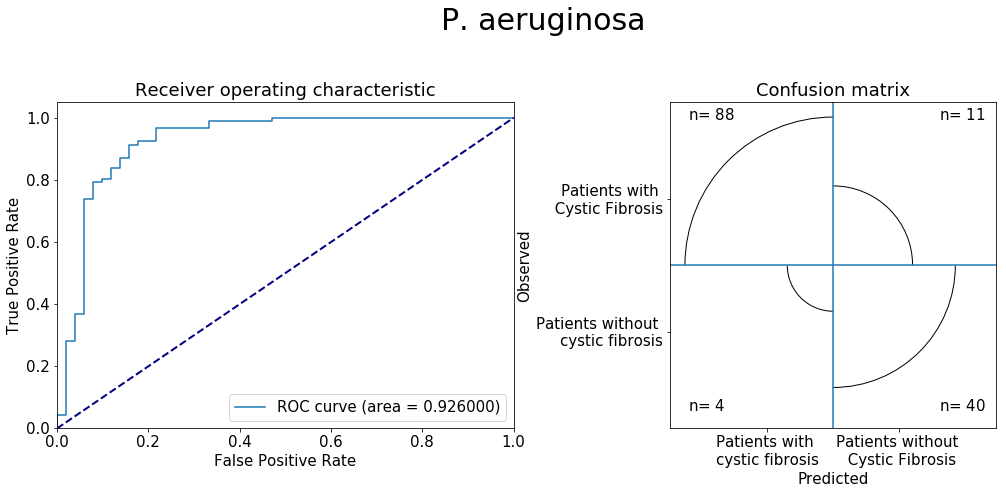

In [30]:
selected_features = selected_features_final.index.tolist()
# selected_features  = sorted_features[:240].index
clf = LinearSVC(penalty="l2", max_iter = 10000, class_weight = 'balanced')
matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, axes = plt.subplots(1,2, figsize = (18, 6))

lw = 2
y_score = clf.fit(data_FS[:,selected_features], labels_FS).decision_function(data_holdout[:,selected_features])
fpr, tpr, _ = roc_curve(labels_holdout, y_score)
roc_auc_multi = auc(fpr, tpr)
axes[0].plot(fpr, tpr, label='ROC curve (area = %f)'%(round(roc_auc_multi, 3)))
axes[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver operating characteristic')
axes[0].legend(loc="lower right")

predicted = clf.fit(data_FS[:,selected_features], labels_FS).predict(data_holdout[:,selected_features])
conf_m = confusion_matrix(labels_holdout,predicted)

axes[1].axvline(0)
axes[1].axhline(0)
# ax=axes[1].gca()

for count,indices in enumerate([[1,1], [1,0], [0,0], [0,1]]):
    r1 = np.log(conf_m[indices[0]][indices[1]])
    c1 = matplotlib.patches.Arc((0,0), r1, r1, angle = 90, theta1 = 90*(count), theta2 = 90*(count+1))
    axes[1].add_patch(c1)

axes[1].text(-2.2, 2.2, '$\it{n}$= %d'%conf_m[1,1])
axes[1].text(1.6, 2.2, '$\it{n}$= %d'%conf_m[0,1])
axes[1].text(1.6, -2.2, '$\it{n}$= %d'%conf_m[0,0])
axes[1].text(-2.2, -2.2, '$\it{n}$= %d'%conf_m[1,0])

axes[1].axis('scaled')
axes[1].set_xticks([-1, 1])
axes[1].set_xticklabels(['Patients with \ncystic fibrosis','Patients without \n Cystic Fibrosis'])
axes[1].set_xlabel('Predicted')
axes[1].set_yticks([-1, 1])
axes[1].set_yticklabels(['Patients without \ncystic fibrosis','Patients with \n Cystic Fibrosis'])
axes[1].set_ylabel('Observed')
axes[1].set_title('Confusion matrix')

fig.suptitle('P. aeruginosa', y = 1.1, fontsize = 30)

In [20]:
directory = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/allele_matrix/'
col_rows = pickle.load(open('%s/col_rows.p'%directory, 'rb'))
input_data = np.load('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/machine_learning/input_data.npz')
train_index = input_data['train_index']
test_index = input_data['test_index']

In [21]:
FT_LRI = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/FT_LRI_f.csv', dtype = {'Genome ID':str}).set_index('Genome ID')

In [22]:
holdout_gids = col_rows[0][test_index]

# predicted to be from CF patient, but actually isn;t
FT_LRI.loc[set(holdout_gids[predicted == 1]) & set(holdout_gids[labels_holdout == 0])]['Isolation Source']

Genome ID
287.7535    sputum of adult cystic fibrosis patient
287.7492          sputum of cystic fibrosis patient
287.7499    sputum of adult cystic fibrosis patient
287.4561                                     sputum
287.7494          sputum of cystic fibrosis patient
287.2547                     cystic fibrosis airway
287.1972                                     sputum
287.7596    sputum of adult cystic fibrosis patient
287.4263                                     sputum
287.5758                     bronchoalveolar lavage
287.5763                     bronchoalveolar lavage
287.8032                                respiratory
Name: Isolation Source, dtype: object

In [23]:
FT_LRI.loc[holdout_gids[predicted != labels_holdout]]['Isolation Source']

287.4561                                     sputum
287.7499    sputum of adult cystic fibrosis patient
287.7596    sputum of adult cystic fibrosis patient
287.1972                                     sputum
287.5763                     bronchoalveolar lavage
287.8032                                respiratory
287.7535    sputum of adult cystic fibrosis patient
287.7949                                     Sputum
287.7948                     bronchoalveolar lavage
287.9104                                     Sputum
287.7492          sputum of cystic fibrosis patient
287.9175                                     Sputum
287.7494          sputum of cystic fibrosis patient
287.4263                                     sputum
287.9150                                     Sputum
287.5758                     bronchoalveolar lavage
287.2547                     cystic fibrosis airway
Name: Isolation Source, dtype: object

#d check for overlap with known adaptive genes to benchmark the approach

In [10]:
cdhit_directory = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/pseudomonas_pangenome_cdhit.clstr'
cdhit_clusters = get_cdhit_clusters(cdhit_directory)
cdhit_clusters_rev = {y:x for x,z in cdhit_clusters.items() for y in z}

blast_hits = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/BR_results/blast_hits.p', 'rb'))
list52_generous = [cdhit_clusters_rev[x] for key, val in blast_hits.items() for ref_gene, mapped_genes in val.items() for x in mapped_genes]

output_directory = '/home/yara/Documents/cystic_fibrosis/data/pseudomonas/allele_matrix/'
allele2cdhit = pickle.load(open('%s/allele2cdhit.p'%output_directory, 'rb'))
allele2cdhit_rev = defaultdict(list)
for allele, cdhit in allele2cdhit.items():
    allele2cdhit_rev[cdhit].append(allele)
    
SF_cdhit = {allele2cdhit['Allele_%d'%x] for x in selected_features_final.index}
len(SF_cdhit & set(list52_generous))/len(SF_cdhit)

In [140]:
list(allele2cdhit.items())[0]

('Allele_312600', 'Cluster 11915')

In [41]:
set(selected_features) & set(list52_alleleId)

{44693, 122337, 205446, 287830, 288872}

In [47]:
all_rows[selection_model_id][44693], all_rows[selection_model_id][122337], all_rows[selection_model_id][205446], all_rows[selection_model_id][287830], all_rows[selection_model_id][288872]

(0.04977811898184464,
 -0.066240840389509,
 0.06084511698082329,
 -0.17065523141574912,
 -0.06387075869145441)

In [94]:
blast_hits = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/pangenome/BR_results/blast_hits.p', 'rb'))
list52_generous = [cdhit_clusters_rev[x] for key, val in blast_hits.items() for ref_gene, mapped_genes in val.items() for x in mapped_genes]
len(list52_generous)

1455

In [98]:
called = set()
for selection_model_id in all_rows.keys():
    if 'RandomForestClassifier' not in selection_model_id:
        s1 = {allele2cdhit['Allele_%d'%x] for x in all_rows[selection_model_id]}
        print(selection_model_id, len(s1 & set(list52_generous))/len(s1)) #, {allele2cdhit['Allele_%d'%x] for x in s1} & set(list52_generous) )
#         called.update({allele2cdhit['Allele_%d'%x] for x in s1 & set(list52_alleleId)})
#         called.update({allele2cdhit['Allele_%d'%x] for x in s1} & set(list52_generous) )

LinearSVC - C=0 - random 0.22007722007722008
LogisticRegression - C=2 - random 0.21022727272727273
LogisticRegression - C=1 - random 0.1971326164874552
LogisticRegression - C=0 - random 0.19696969696969696
LinearSVC - C=2 - random 0.21031746031746032
LinearSVC - C=1 - random 0.228310502283105


In [102]:
len(list52_generous)/len(cdhit_clusters)

0.05284951509207802

In [83]:
called

{'Cluster 10116',
 'Cluster 1240',
 'Cluster 14617',
 'Cluster 2506',
 'Cluster 391',
 'Cluster 3968',
 'Cluster 557',
 'Cluster 746'}

In [70]:
locus_tags = pickle.load(open('/home/yara/Documents/cystic_fibrosis/data/pseudomonas/list52genes.p', 'rb'))

In [ ]:
gyrA, gyrB, mexA, mexB, mexR, mexS, mexZ, nalD, nfxB and oprD

In [71]:
{x:locus_tags[x] for x in called}

{'PA0004': 'gyrB',
 'PA0426': 'mexB',
 'PA2602': '',
 'PA3064': 'pelA',
 'PA3574': 'nalD',
 'PA4020': 'mpl',
 'PA4963': ''}

In [63]:
s1 & set(list52_alleleId)

{44693, 122337, 287830, 288872}

In [ ]:
cdhit_clusters_rev